<a href="https://colab.research.google.com/github/srivennela-128/OIB-SIP/blob/main/Project_3_Proposal_Level_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required libraries (Python only)
!pip install pandas numpy matplotlib seaborn scikit-learn plotly xgboost shap joblib -q


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
# Upload manually: run this and select AB_NYC_2019.csv
from google.colab import files
uploaded = files.upload()

# Read the uploaded file
import io
df = pd.read_csv(io.BytesIO(uploaded['AB_NYC_2019.csv']))


Saving AB_NYC_2019.csv to AB_NYC_2019.csv


In [ ]:
df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,48895.0,NaN,NaN,NaN,19017143.23618,10983108.38561,2539.0,9471945.0,19677284.0,29152178.5,36487245.0
name,48879,47905,Hillside Hotel,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_id,48895.0,NaN,NaN,NaN,67620010.64661,78610967.032667,2438.0,7822033.0,30793816.0,107434423.0,274321313.0
host_name,48874,11452,Michael,417,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood_group,48895,5,Manhattan,21661,NaN,NaN,NaN,NaN,NaN,NaN,NaN
neighbourhood,48895,221,Williamsburg,3920,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,48895.0,NaN,NaN,NaN,40.728949,0.05453,40.49979,40.6901,40.72307,40.763115,40.91306
longitude,48895.0,NaN,NaN,NaN,-73.95217,0.046157,-74.24442,-73.98307,-73.95568,-73.936275,-73.71299
room_type,48895,3,Entire home/apt,25409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,48895.0,NaN,NaN,NaN,152.720687,240.15417,0.0,69.0,106.0,175.0,10000.0


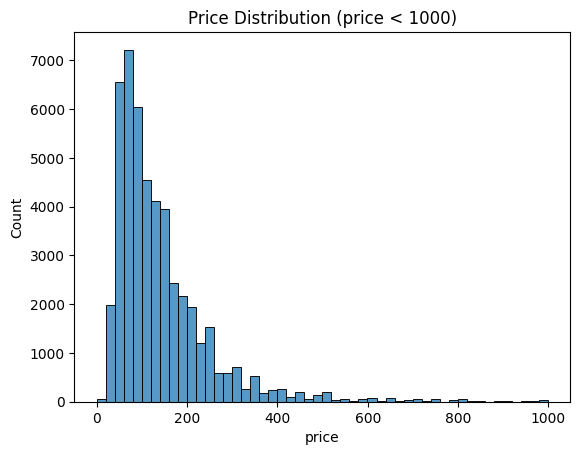

In [ ]:
sns.histplot(df[df.price < 1000].price, bins=50)
plt.title("Price Distribution (price < 1000)")
plt.show()


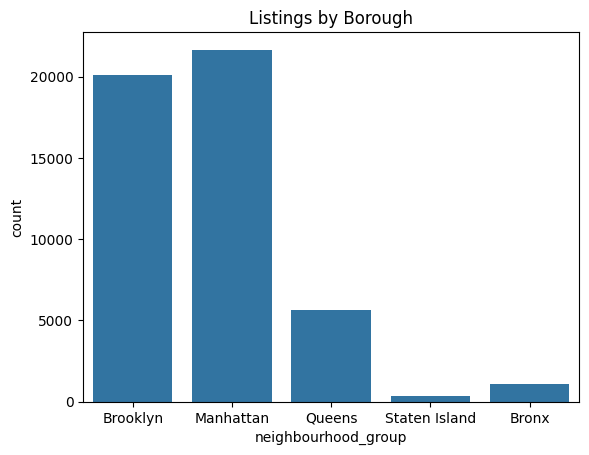

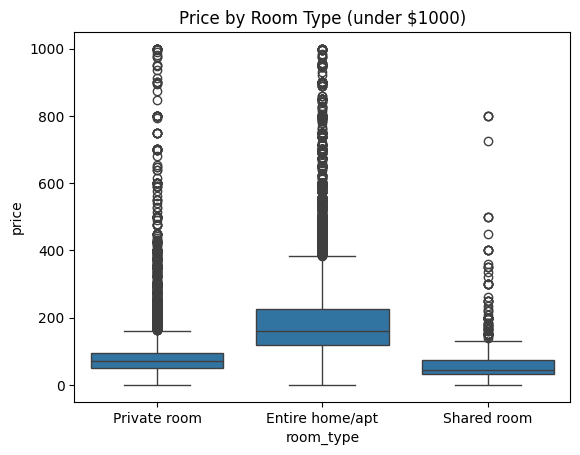

In [ ]:
sns.countplot(x='neighbourhood_group', data=df)
plt.title('Listings by Borough')
plt.show()

sns.boxplot(x='room_type', y='price', data=df[df.price < 1000])
plt.title('Price by Room Type (under $1000)')
plt.show()


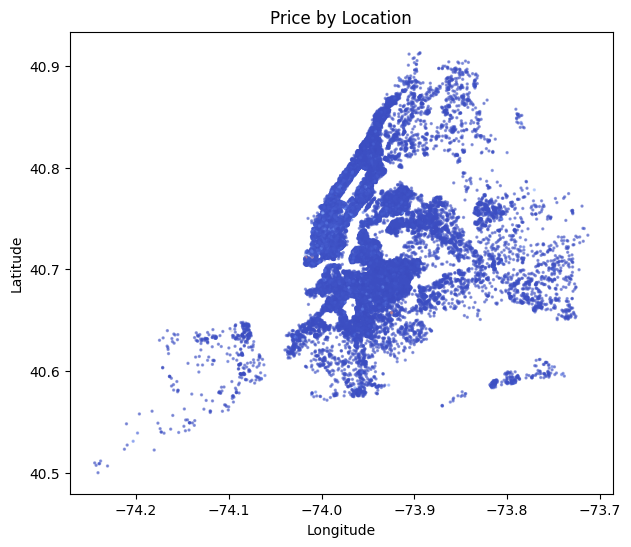

In [ ]:
plt.figure(figsize=(7,6))
plt.scatter(df.longitude, df.latitude, c=df.price, cmap='coolwarm', s=2, alpha=0.5)
plt.title('Price by Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
# Drop or fill missing
df = df[df.price > 0].copy()  # Remove invalid prices
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

max_date = df['last_review'].max()
df['days_since_last_review'] = (max_date - df['last_review']).dt.days.fillna(-1)

# Cap price at 99th percentile
cap = df.price.quantile(0.99)
df['price_capped'] = np.where(df.price > cap, cap, df.price)

# Confirm
df[['price','price_capped','days_since_last_review']].head()


,price,price_capped,days_since_last_review
0,149,149.0,262.0
1,225,225.0,48.0
2,150,150.0,-1.0
3,89,89.0,3.0
4,80,80.0,231.0


In [ ]:
features = ['latitude','longitude','minimum_nights','number_of_reviews',
            'reviews_per_month','availability_365','calculated_host_listings_count',
            'days_since_last_review','neighbourhood_group','room_type']

target = 'price_capped'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor

num_features = ['latitude','longitude','minimum_nights','number_of_reviews',
                'reviews_per_month','availability_365','calculated_host_listings_count',
                'days_since_last_review']
cat_features = ['neighbourhood_group','room_type']

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1))
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'minimum_nights',
                                                   'number_of_reviews',
                                                   'reviews_per_month',
                                                   'availability_365',
                                                   'calculated_host_listings_count',
                                                   'days_since_last_review']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['neighbourhood_group',
                                                   'room_type'])])),
                ('regressor',
                 RandomForestRegressor(n_estimators=150, n_jobs=-1,
                                       random_state=42))])

RMSE: 93.53
MAE: 52.73
R²: 0.410


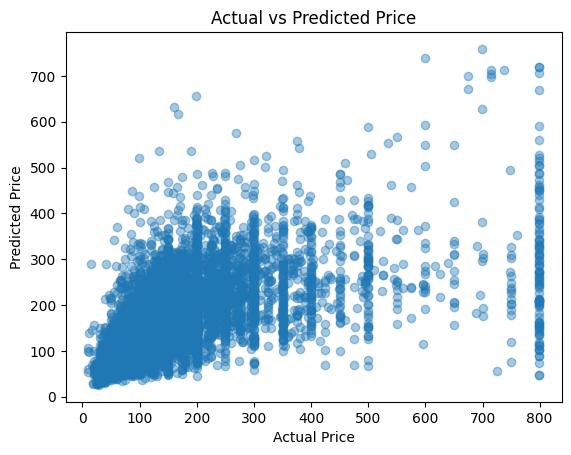

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

plt.scatter(y_test, y_pred, alpha=0.4)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price")
plt.show()


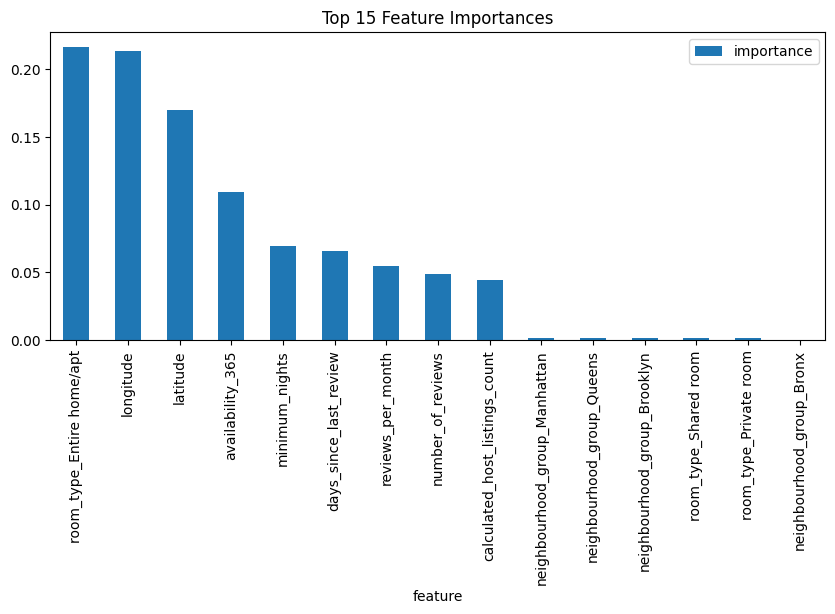

In [ ]:
# Extract feature names after one-hot encoding
cat_encoded = model.named_steps['preprocessor'].named_transformers_['cat']\
    .named_steps['encoder'].get_feature_names_out(cat_features)
feature_names = np.concatenate([num_features, cat_encoded])

importances = model.named_steps['regressor'].feature_importances_
fi = pd.DataFrame({'feature': feature_names, 'importance': importances})
fi.sort_values('importance', ascending=False).head(15).plot.bar(x='feature', y='importance', figsize=(10,4))
plt.title('Top 15 Feature Importances')
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CAvideos.csv to CAvideos.csv


In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm nltk spacy gensim pyLDAvis wordcloud plotly streamlit prophet jupyterlab joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 99.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.1 MB/s eta 0:00:00


In [ ]:
# src/data_utils.py
import pandas as pd
import json
from pathlib import Path

def load_videos_csv(path):
    df = pd.read_csv(path, parse_dates=['trending_date','publish_time'], low_memory=False)
    return df

def load_category_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # flatten id -> title
    mapping = {item['id']: item['snippet']['title'] for item in data['items']}
    return mapping